# Reconstruction with real data

In [2]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio
import jax

import mrcfile

plt.rcParams["figure.figsize"]=8,8

### Read the data

In [4]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
star_file = "/Extract/job018/particles.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  4501
load_data: data loaded, time:  5.1236090660095215


In [5]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(4501, 256, 256)
(4501,)
(4501, 3)
(4501, 2)
(4501, 9)


### Only keep the first N points (to avoid out of memory error)

In [6]:
N = 10000
imgs = imgs0[:N]
pixel_size = pixel_size0[:N]
angles = angles0[:N]
shifts = shifts0[:N]
ctf_params = ctf_params0[:N]

### Some angle filtering

In [7]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Noise

First, decide on the dimensions of the empty corners to use for noise estimation:

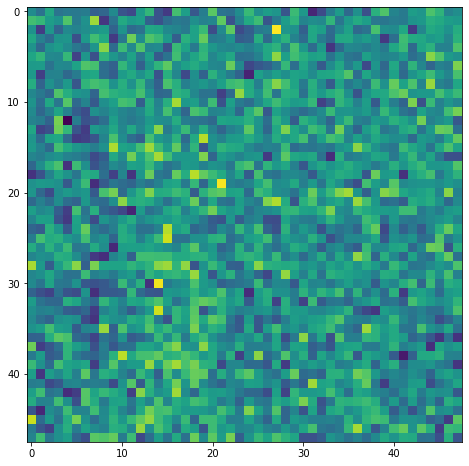

In [9]:
plt.imshow(jnp.mean(imgs0[:,:48,:48], axis=0))

In [11]:
sigma_noise = estimate_noise_imgs(imgs0, nx_empty = 48, nx_final = 32)

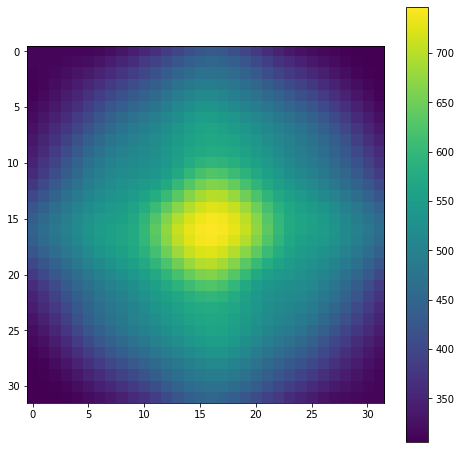

In [12]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

### Take the FFT of the images

In [14]:
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])

#del(imgs)

### Create the grids

In [16]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 2.56000000e+02]


### Crop images to 32 x 32 

In [17]:
nx = 32
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[3.13873258e-03 3.20000000e+01]


### Before further processing, vectorize the images, create mask etc

In [18]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(4501, 1024)


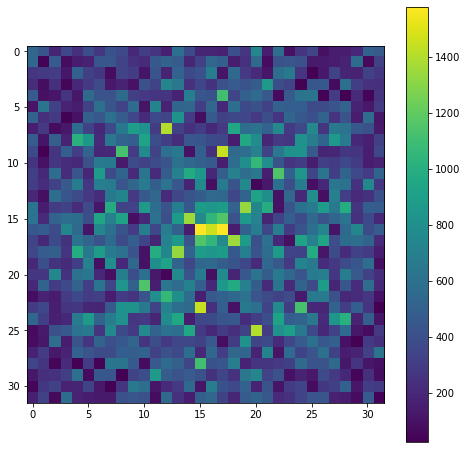

In [19]:
plt.imshow(jnp.abs(jnp.fft.fftshift(jnp.array(imgs_f[101].reshape(nx,nx)))));plt.colorbar()

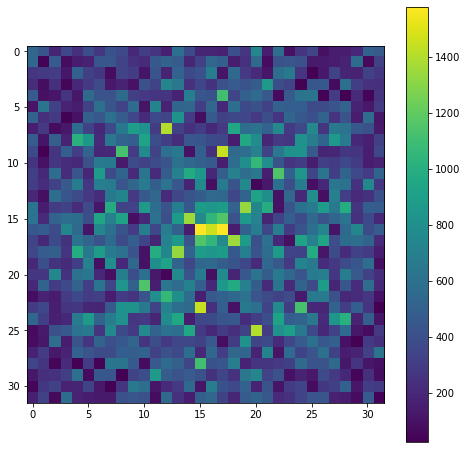

In [20]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

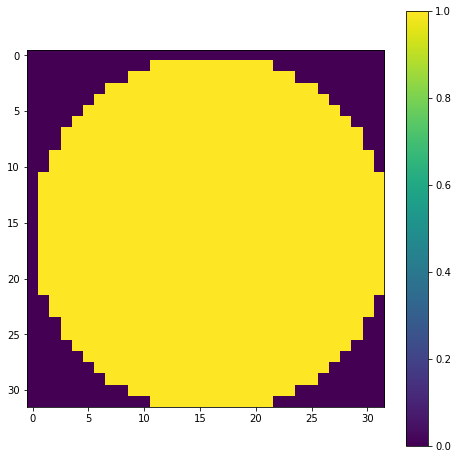

In [21]:
centre = (0,0,0)
radius = 0.05
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)


mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Forward model and loss functon

In [22]:
alpha = 0.1

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

Test the functions above with a random volume

In [105]:
vf = jnp.array(np.random.randn(nx,nx,nx))
sf = slice_func(vf, angles[0], shifts[0], ctf_params[0])
sf.shape

(1024,)

In [106]:
start = time.time()
ll = grad_loss_volume(vf, angles[0], shifts[0], ctf_params[0], imgs_f[0], sigma=1)
print(time.time()-start)
print(ll.shape)

1.5319983959197998
(32, 32, 32)


In [107]:
batch_size = 10
idx = np.random.default_rng().choice(N, size=batch_size, replace = False)

start = time.time()
ll = grad_loss_volume_batched(vf, angles[idx], shifts[idx], ctf_params[idx], imgs_f[idx], sigma=1)
print(time.time()-start)
print(ll.shape)

2.16304087638855
(32, 32, 32)


### Ab initio

In [17]:
x_grid[0]*x_grid[1]/2

0.05021972132474

In [18]:
x_grid[0]

0.00313873258279625

0.1
1.1
0.1


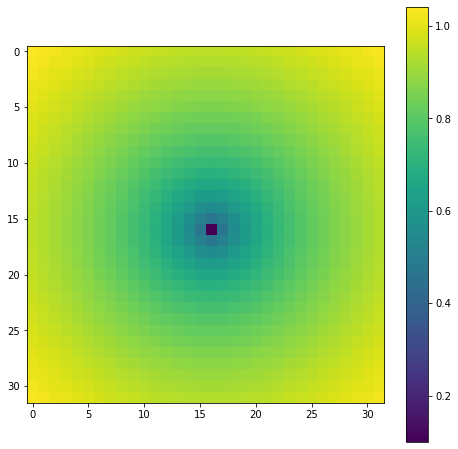

In [19]:
P = get_preconditioner(x_grid) 
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 0.1
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

In [28]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [43]:
#sys.stdout = sys.__stdout__

In [168]:
N_samples = 100000
N_iter = 10000

dr = 0.005
#dr = 0.003
#radius = 0.01
radius = 0.03
alpha = 1e-8
#alpha = 1e-9

use_sgd = True

N_cg_iter = 10000
#eps_cg = 3e-5
eps_cg = 1e-5

N_sgd_iter = 10000
batch_size = 300
learning_rate = 1000
#learning_rate = 10000
P = None
#eps_gd = 1e-8
eps_gd = 1e-7

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

out_dir = '../data/relion/'
imgs_f = imgs_f.reshape([N, nx*nx])


v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius, dr, alpha, eps_vol, 'tri', True, True, True, out_dir)

  sgd epoch 0: mean gradient = 8.719149135766833e-07
  sgd epoch 50: mean gradient = 7.929418432029934e-07
  sgd epoch 100: mean gradient = 7.218982708302299e-07
  sgd epoch 150: mean gradient = 6.579265517743594e-07
  sgd epoch 200: mean gradient = 6.002600497649272e-07
  sgd epoch 250: mean gradient = 5.482241548433552e-07
  sgd epoch 300: mean gradient = 5.01221415075744e-07
  sgd epoch 350: mean gradient = 4.5871865253957465e-07
  sgd epoch 400: mean gradient = 4.202456125759674e-07
  sgd epoch 450: mean gradient = 3.853814592606967e-07
  sgd epoch 500: mean gradient = 3.5375283548286465e-07
  sgd epoch 550: mean gradient = 3.250272141924252e-07
  sgd epoch 600: mean gradient = 2.989112038366338e-07
  sgd epoch 650: mean gradient = 2.7513760111280006e-07
  sgd epoch 700: mean gradient = 2.534746105456726e-07
  sgd epoch 750: mean gradient = 2.337117272079929e-07
  sgd epoch 800: mean gradient = 2.1566032964375482e-07
  sgd epoch 850: mean gradient = 1.991563181152689e-07
  sgd epoc

KeyboardInterrupt: 

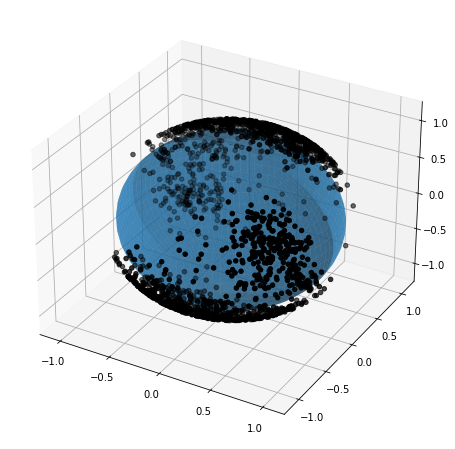

In [160]:
plot_angles(angles_rec[:2000])

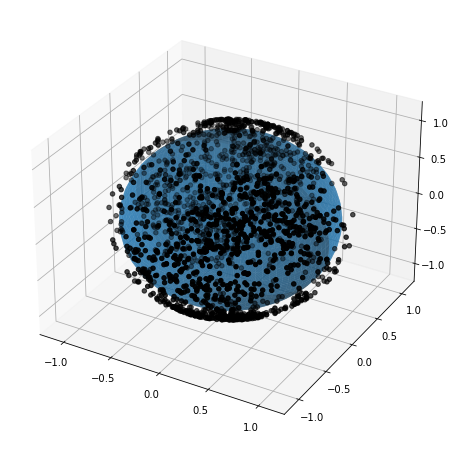

In [194]:
plot_angles(angles_rec[:2000])

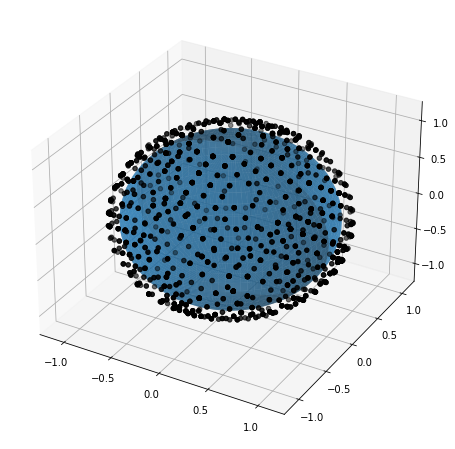

In [30]:
plot_angles(angles[:2000])

### CG

In [50]:
alpha = 1e-4
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))
#sigma_noise = jnp.max(sigma_noise) * jnp.ones(sigma_noise.shape)

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

#v0 = jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx))
v0 = jnp.zeros([nx,nx,nx])* 1j
N_iter = 101

#N2 = jnp.floor(N/2).astype(jnp.int64)
N2 = 10000
AA1, Ab1 = get_cg_vol_ops(grad_loss_volume_sum, angles_rec[:N2], shifts[:N2], ctf_params[:N2], imgs_f[:N2], v0.shape, sigma_noise)

In [51]:
vcg1, _ = conjugate_gradient(AA1, Ab1, v0, N_iter, verbose = True)

  cg iter 0 ||r|| = 2.229473759128272e-05
  cg iter 50 ||r|| = 5.431257166781235e-07
  cg iter 100 ||r|| = 3.6602226546659477e-07


In [52]:
print("Final loss function (over all data) = ", jnp.mean(loss_func_batched(vcg1, angles_rec, shifts, ctf_params, imgs_f, sigma_noise))/(nx*nx))

Final loss function (over all data) =  2.2127388709015983


In [39]:
l2sq(vcg1)*alpha/2

DeviceArray(0.5374013, dtype=float64)

In [295]:
#sgd_loss_func(vcg1, jnp.arange(N))

In [296]:
#AA2, Ab2 = get_cg_vol_ops(grad_loss_volume_sum, angles[N2:], shifts[N2:], ctf_params[N2:], imgs_f[N2:], v0.shape)

#vcg2, _ = conjugate_gradient(AA1, Ab1, vcg1, 100, verbose = True)

In [40]:
i = 110
s0 = slice_func(v_rec, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

NameError: name 'v_rec' is not defined

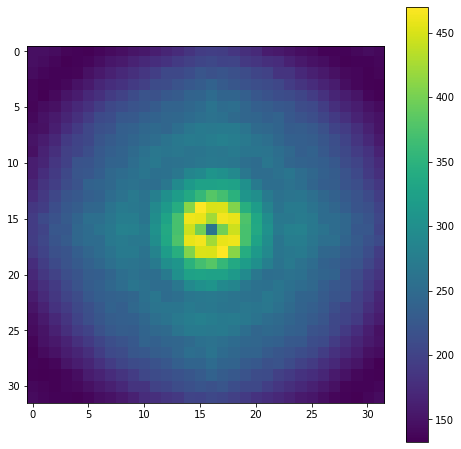

In [41]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([32,32]))); plt.colorbar()

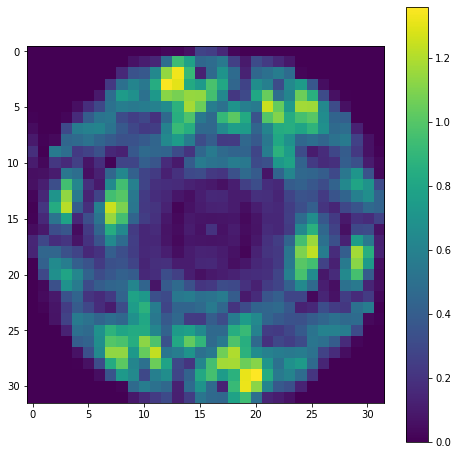

In [42]:
i = 100
s0 = slice_func(vcg1, angles_rec[i], shifts[i], ctf_params[i])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

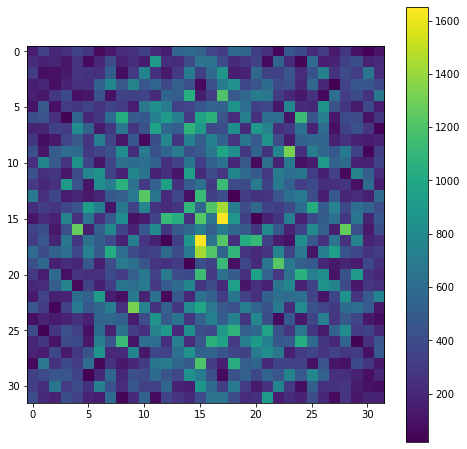

In [43]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[i]).reshape(nx,nx))); plt.colorbar()

In [44]:
resid = s0 - imgs_f[i]
d = jnp.real(jnp.conj(resid)*resid)/(2*sigma_noise**2)

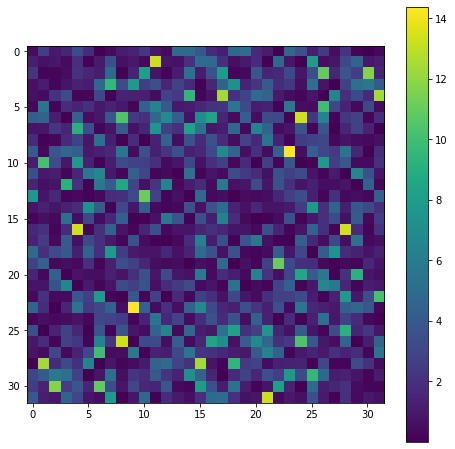

In [45]:
plt.imshow(jnp.fft.fftshift(d.reshape([32,32]))); plt.colorbar()

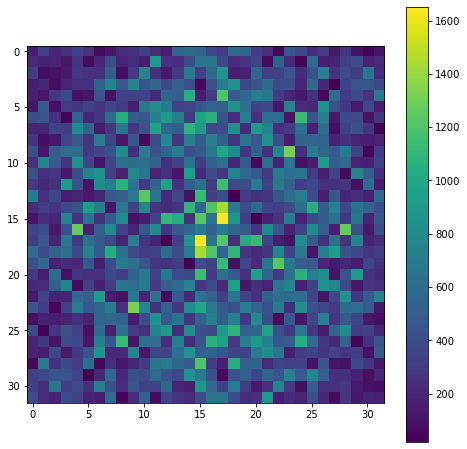

In [46]:
plt.imshow(jnp.abs(jnp.fft.fftshift(resid.reshape([32,32])))); plt.colorbar()

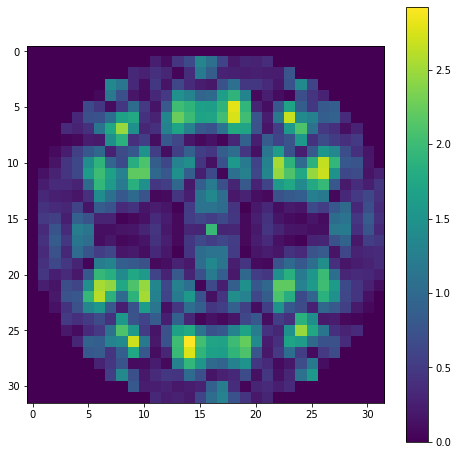

In [47]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vcg1[:,0,:]))); plt.colorbar()

In [48]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec))))
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

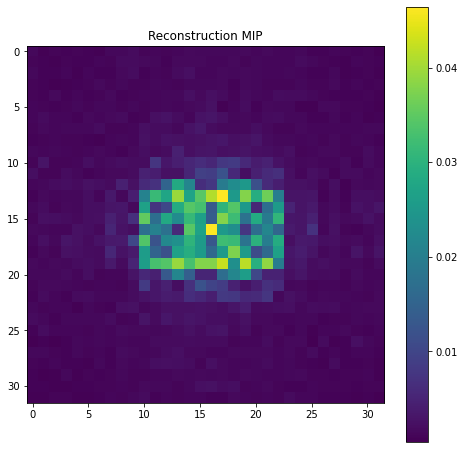

In [49]:
mip_z(jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))))
plt.colorbar()
plt.title('Reconstruction MIP')

In [319]:
vr1 = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcg1))) 

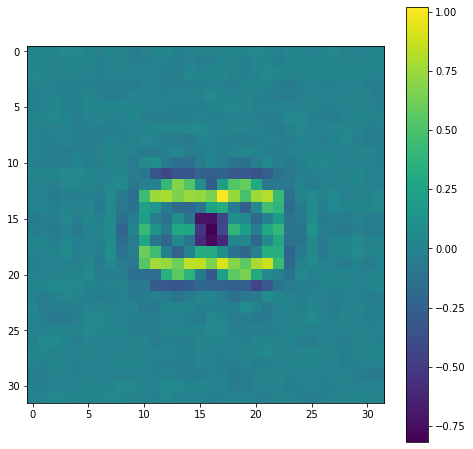

In [320]:
plt.imshow(vr1[:,:,16]); plt.colorbar()

In [321]:
verr = vcg1 - v_rec
plt.imshow(jnp.abs(jnp.fft.fftshift(verr[0,:,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [322]:
jnp.max(jnp.abs(vcg1))

DeviceArray(116.88976, dtype=float64)

In [323]:
jnp.max(jnp.abs(v_rec))

NameError: name 'v_rec' is not defined

### Write volume to file

In [324]:
with mrcfile.new('../data/reconstruction_data_32_cg.mrc', overwrite=True) as mrc:
    mrc.set_data(vr1.astype(np.float32))

### CG - choosing $\alpha$

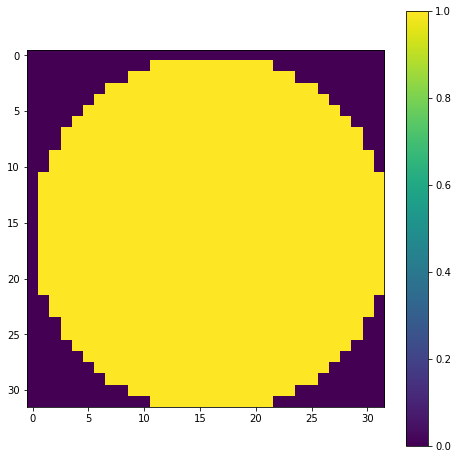

In [23]:
centre = (0,0,0)
radius = 0.05
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [24]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

Estimate the noise:

In [25]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)

sigma noise min = 305.89374
sigma noise max = 746.633
sigma noise mean = 471.57767


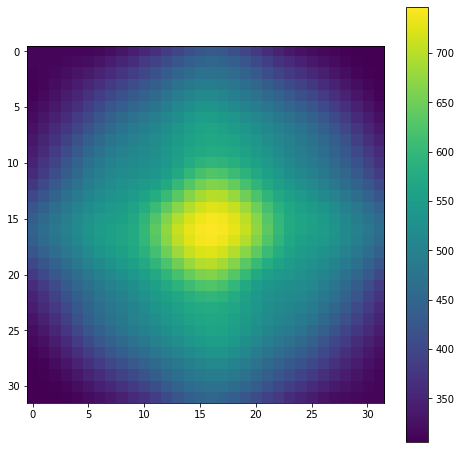

In [26]:
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [32]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [33]:
N_iter = 50100
#eps = 3e-5
eps = 1e-3
#eps = 1e-4
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
vcgs = []
fids = []
regs = []
losss = []

In [34]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_rec, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-07
  cg iter 0 ||r|| = 0.0006001798556911162
  fid = 0.750994520656327
  reg = 3614.597671774995
  loss = 0.38128061660300355
  Time = 17.123098134994507
alpha = 1.1e-06
  cg iter 0 ||r|| = 0.00010715767255049417
  fid = 0.7791805107492646
  reg = 115.22419415845356
  loss = 0.3916182011918212
  Time = 9.49426817893982
alpha = 1e-05
  cg iter 0 ||r|| = 1.2893519973519645e-05
  fid = 0.7866518538531901
  reg = 1.6681693205604207
  loss = 0.39359283401788475
  Time = 9.08115530014038
alpha = 0.0001
  cg iter 0 ||r|| = 1.3029533561352562e-06
  fid = 0.7876166664477375
  reg = 0.0170354995260908
  loss = 0.3938355900231105
  Time = 9.483663558959961
alpha = 0.001
  cg iter 0 ||r|| = 1.304329291536431e-07
  fid = 0.7877148313299258
  reg = 0.0001707149793372883
  loss = 0.39386014710463224
  Time = 9.546032905578613
alpha = 0.01
  cg iter 0 ||r|| = 1.3044670449494366e-08
  fid = 0.7877246649177362
  reg = 1.707510404891455e-06
  loss = 0.3938626056605328
  Time = 9.11161971092224

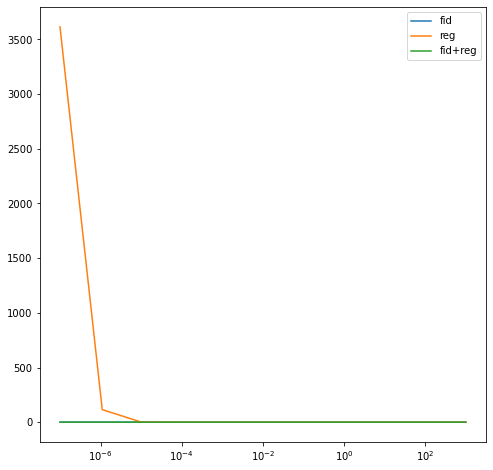

In [35]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

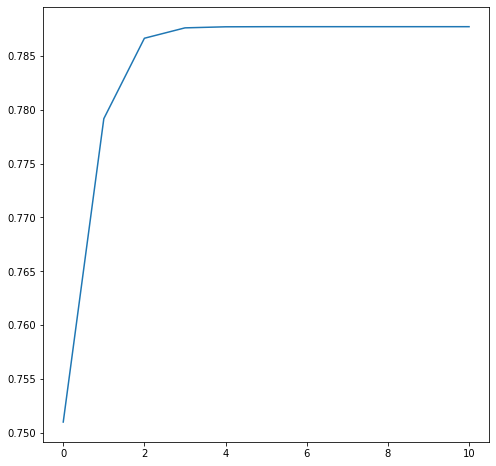

In [36]:
plt.plot(fids)

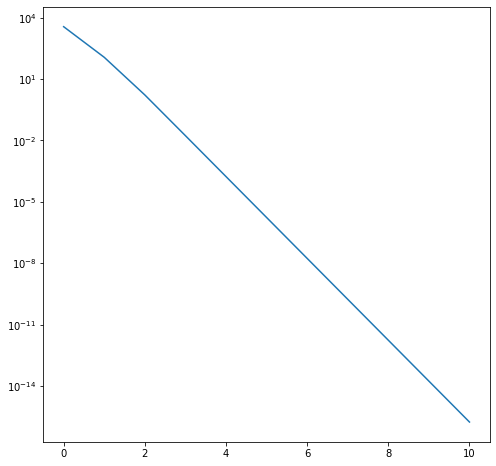

In [37]:
plt.semilogy(regs)

In [39]:
def pixel_wise_fid_fun(v, slice_func_array, angles_, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

Pixel-wise loss for the best reconstruction:

In [40]:
fids[1]

DeviceArray(0.77918051, dtype=float64)

In [41]:
fids[10]

DeviceArray(0.78772576, dtype=float64)

In [44]:
alphas[alpha_idx]

DeviceArray(1.e-07, dtype=float64)

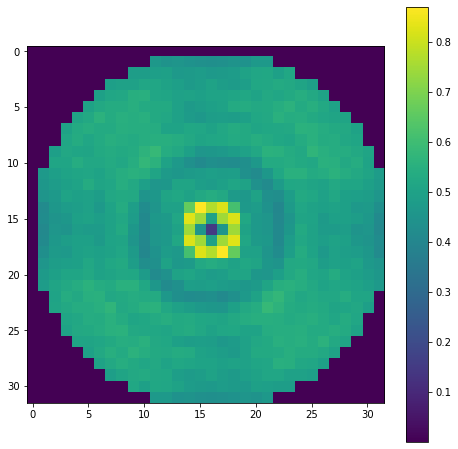

In [55]:
pw_fid = pixel_wise_fid_fun(vcgs[alpha_idx], slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

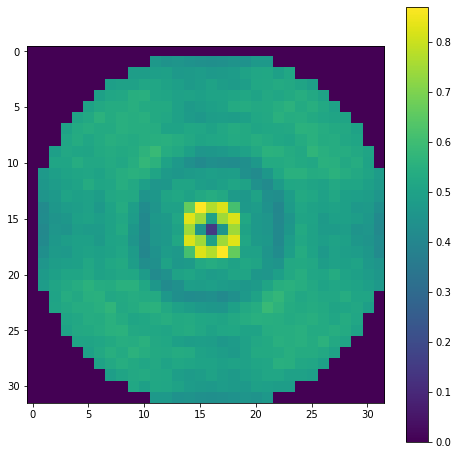

In [56]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [64]:
alpha_idx = 7

1.0


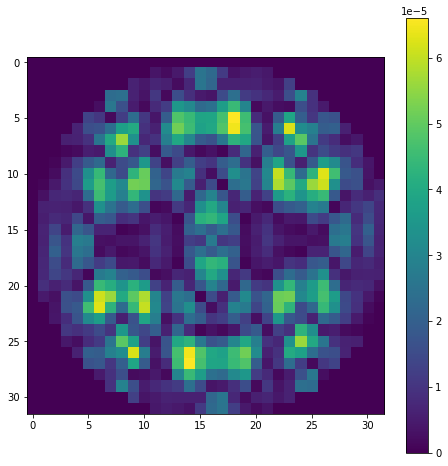

In [65]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

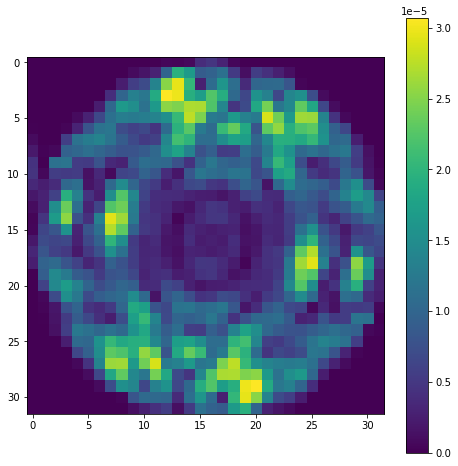

In [66]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_rec[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

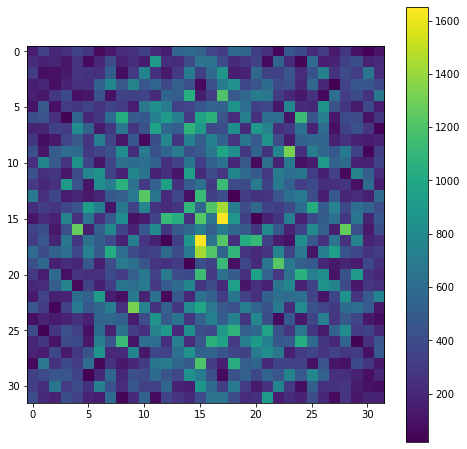

In [67]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

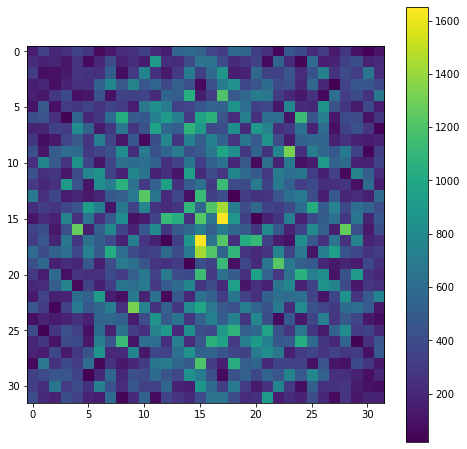

In [68]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

In [69]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

Text(0.5, 1.0, 'Reconstruction MIP')

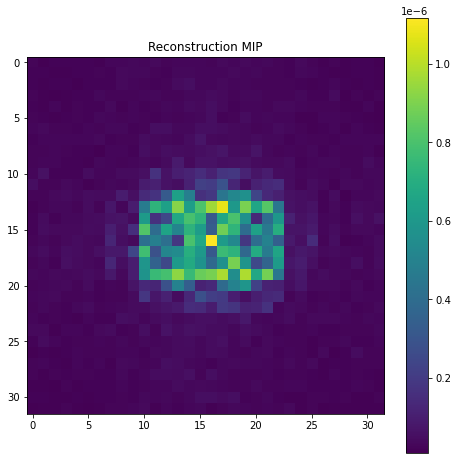

In [70]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')

In [71]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [74]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(11, 32)

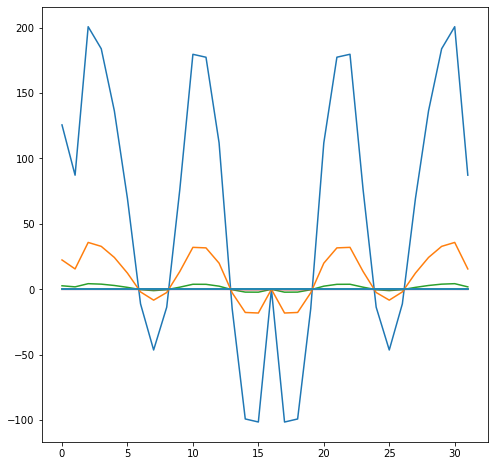

In [76]:
for i in range(11):
    plt.plot(jnp.real(vcgs_s[i]))

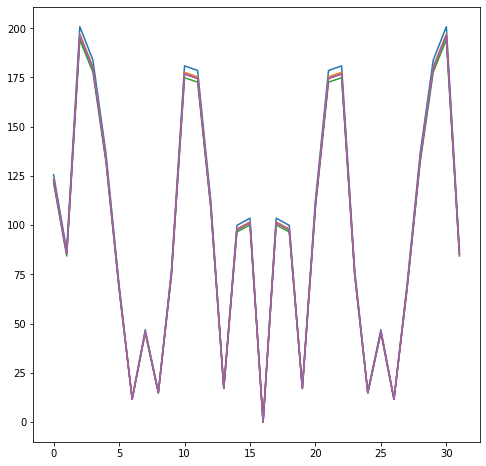

In [107]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*5.5)
plt.plot(jnp.abs(vcgs_s[2])*45)
plt.plot(jnp.abs(vcgs_s[3])*450)
plt.plot(jnp.abs(vcgs_s[10])*4.5e9)


### FSC, orientations, standard deviation for each voxel etc

In [29]:
vcg2=vcg1

In [30]:
#dr = 0.01
dr = 0.05
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid, dr)


In [153]:
angles[:50].shape

(50, 3)

In [21]:
rc = rotate_list(x_grid, angles[:2])
_,(_,xyz_idxs) = jax.vmap(find_nearest_eight_grid_points_idx, in_axes = (1,None, None, None))(rc, x_grid, x_grid, x_grid)

In [29]:
#jnp.array_split(xyz_idxs, 100)

In [16]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 100)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches
Adding up number of points from batches


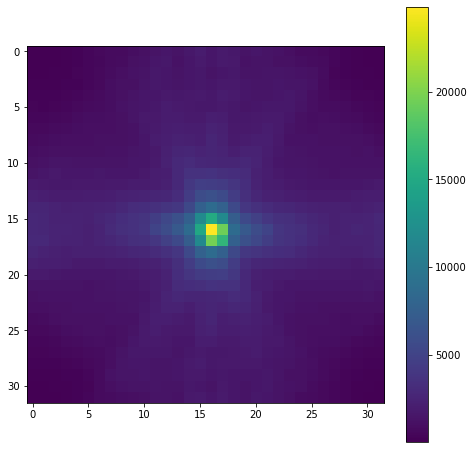

In [18]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [ ]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid, dr = 0.05)

In [ ]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [ ]:
vones = jnp.ones(vcg1.shape)
omega = AA1(vones)
omega = 1/omega

In [ ]:
plt.title("Standard deviation")
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))))); plt.colorbar()

In [ ]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))))); plt.colorbar()

### SGD

### Preconditioner

In [69]:
points_v_nn.shape
P2 = points_v_nn
P2 += 1
P2 = (1/P2**0.1 ) * mask

P2 = P2/jnp.max(P2)

plt.imshow(jnp.fft.fftshift(P2[:,:,0]));plt.colorbar()
print(P2[0,0,0])
print(jnp.max(P2))
print(jnp.min(P2))

NameError: name 'points_v_nn' is not defined

1e-06
1.000001
1e-06


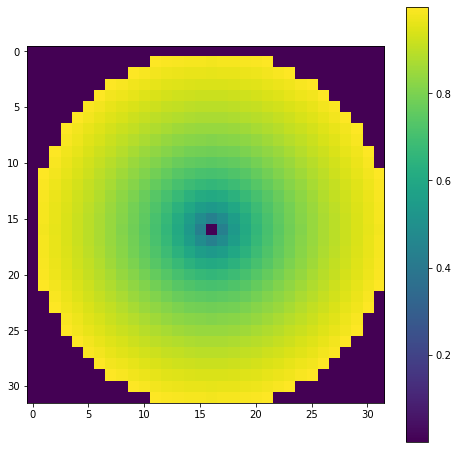

In [34]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

0.02275106763759302
1.0
0.0


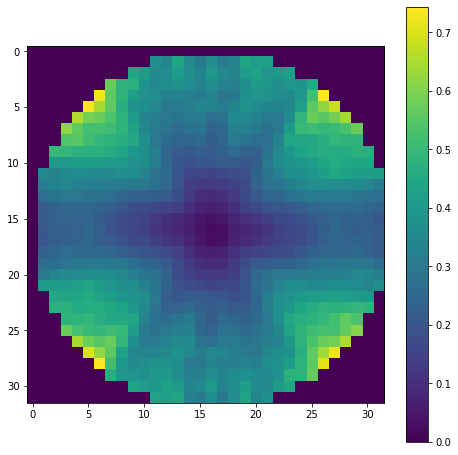

In [236]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### $\alpha$ tuning

In [135]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [110]:
N_epoch = 50100
batch_size = N/4
number_of_batches = N/batch_size
#learning_rate = 100000
learning_rate = 10000

P = None

eps = 3e-5
#eps = 1e-3
#eps = 1e-9
v0 = jnp.zeros([nx,nx,nx])* 1j
alphas = [1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-13]


In [111]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_batched, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_batched, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-08
  sgd epoch 0: mean gradient = 7.80926442566453e-07
  fid = 0.7872904753756327
  reg = 0.2721704989706454
  loss = 0.3936452812350962
  Time = 11.181015253067017
alpha = 1e-07
  sgd epoch 0: mean gradient = 7.781159553567494e-07
  fid = 0.7872910590404724
  reg = 0.2714394046104678
  loss = 0.39364596382328354
  Time = 11.194517374038696
alpha = 1.1e-06
  sgd epoch 0: mean gradient = 7.474021199109664e-07
  fid = 0.7872975189237926
  reg = 0.2634146443167274
  loss = 0.39365339555963624
  Time = 11.940446376800537
alpha = 1e-05
  sgd epoch 0: mean gradient = 5.12491921889041e-07
  fid = 0.7873513303093828
  reg = 0.20133236534937732
  loss = 0.3937078783331473
  Time = 11.205865859985352
alpha = 0.0001
  sgd epoch 0: mean gradient = 5.619594942653915e-08
  fid = 0.7876166027048481
  reg = 0.018451416473834057
  loss = 0.3938378236187822
  Time = 11.222664833068848
alpha = 0.001
  sgd epoch 0: mean gradient = 0.0058650603014824745
  sgd epoch 50: mean gradient = 4.24645068

KeyboardInterrupt: 

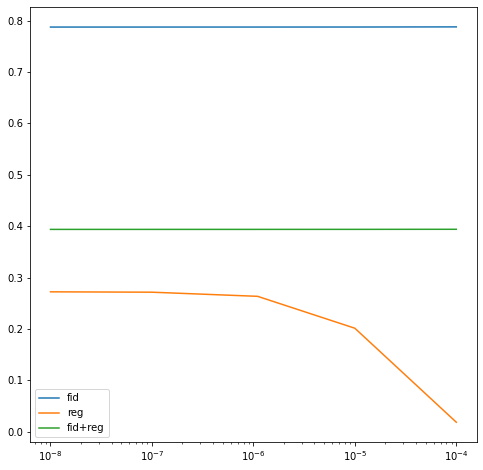

In [114]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

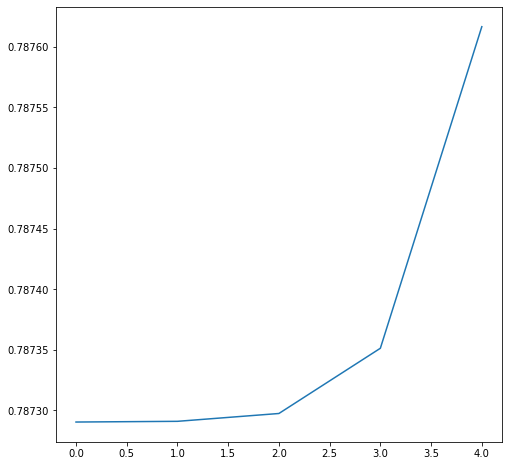

In [115]:
plt.plot(fids)

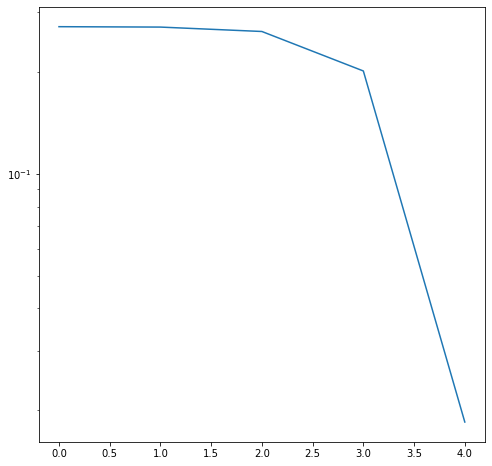

In [116]:
plt.semilogy(regs)

In [383]:
alpha_idx= 3

0.869732870378237


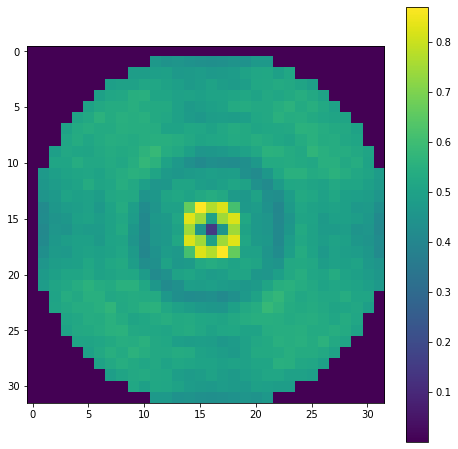

In [117]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.869732870378237


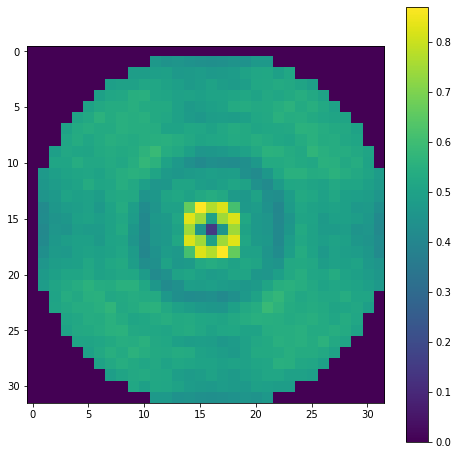

In [118]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

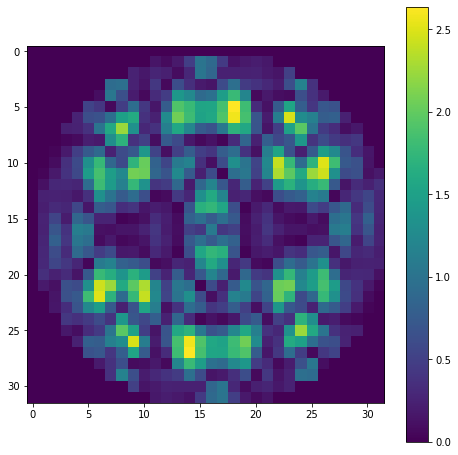

In [119]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [120]:
plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

NameError: name 'v_rec' is not defined

In [121]:
err = vgd - v_rec
plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

NameError: name 'v_rec' is not defined

NameError: name 'v_rec' is not defined

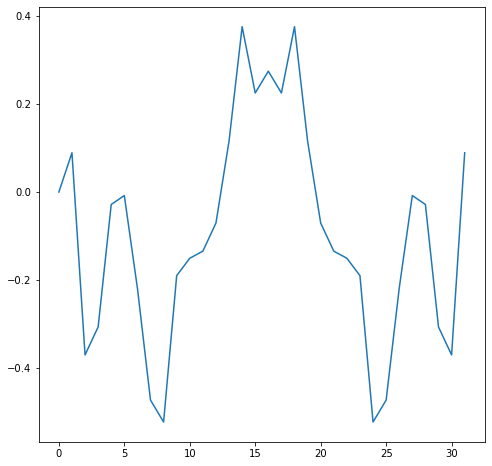

In [122]:
plt.plot(jnp.fft.fftshift(jnp.real(vgd[0,:,0])))
plt.plot(jnp.fft.fftshift(jnp.real(v_rec[0,:,0])))
plt.plot(jnp.fft.fftshift(jnp.real(imgs_f[idx].reshape([32,32])[0,:])))
plt.legend(['vgd', 'vrec', 'img'])

In [ ]:
jnp.max(jnp.abs(imgs_f))

In [135]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))

Text(0.5, 1.0, 'Reconstruction MIP')

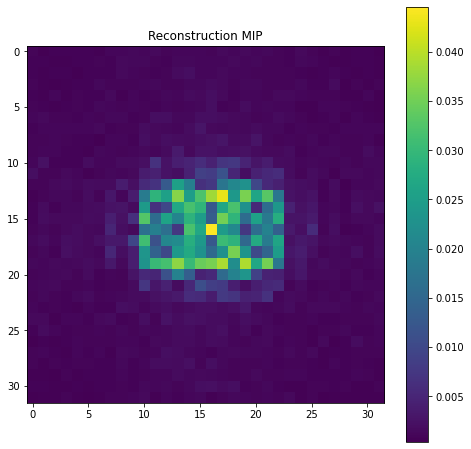

In [124]:
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [125]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

In [136]:
with mrcfile.new('../data/reconstruction_data_32_sgd.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [128]:
idx = 100

In [129]:
slicegd = slice_func(vgds[alpha_idx], angles[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles[idx], shifts[idx], ctf_params[idx])

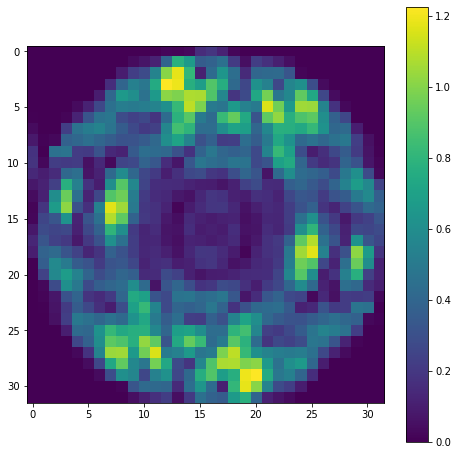

In [130]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([32,32])))); plt.colorbar()

In [132]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

NameError: name 'slicerec' is not defined

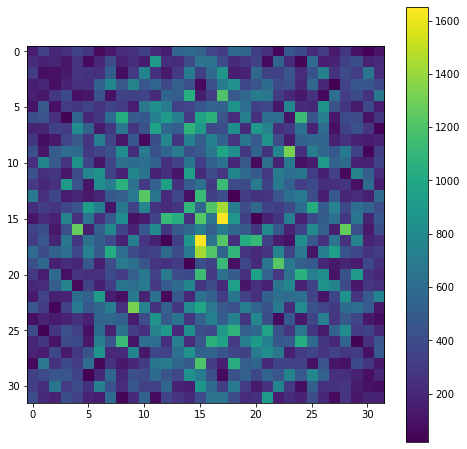

In [133]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [134]:
print(1/2*wl2sq(slicegd, imgs_f[idx], 1/sigma_noise**2))
print(1/2*wl2sq(slicerec, imgs_f[idx], 1/sigma_noise**2))

553.343876582564


NameError: name 'slicerec' is not defined

In [355]:
lossgd = loss_func_sum(vgd, angles, shifts, ctf_params, imgs_f, sigma_noise)
lossrec = loss_func_sum(v_rec, angles, shifts, ctf_params, imgs_f, sigma_noise)

print(lossgd)
print(lossrec)

NameError: name 'v_rec' is not defined

In [356]:
alpha0 = 0 

loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
grad_loss_volume0, grad_loss_volume_batched0, grad_loss_volume_sum0 = get_grad_v_funcs(loss_func0, loss_func_sum0)

In [269]:
lossgd0 = loss_func_sum0(vgd, angles, shifts, ctf_params, imgs_f)
lossrec0 = loss_func_sum0(v_rec, angles, shifts, ctf_params, imgs_f)

print(lossgd0)
print(lossrec0)

117666.1786326568
125930.4384133436


In [270]:
reg_term = lambda v, alpha : 1/(2*v.shape[-1]**2) * alpha * l2sq(v)

In [276]:
print(reg_term(vgd, alpha) + lossgd0)
print(reg_term(v_rec, alpha) + lossrec0)

118950.80871989178
324801.5763731515


In [281]:
imgs_f.shape

(4501, 1024)

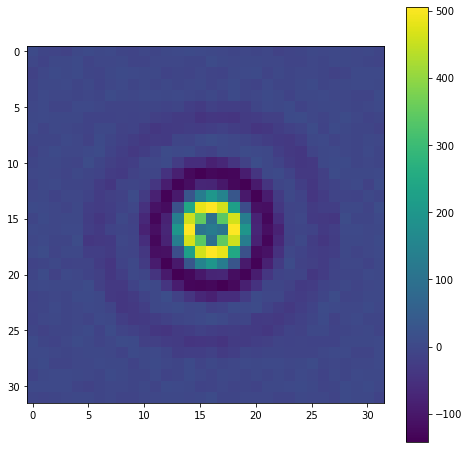

In [395]:
imgs_mean = jnp.mean(jnp.real(imgs_f), axis=0)
plt.imshow(jnp.fft.fftshift((imgs_mean.reshape([32,32]))))
plt.colorbar()

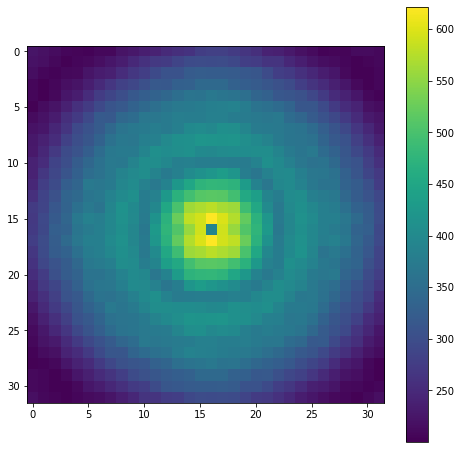

In [373]:
imgs_sd = jnp.sqrt(jnp.mean((jnp.real(imgs_f)-imgs_mean)**2, axis=0))
plt.imshow(jnp.fft.fftshift(imgs_sd.reshape([32,32])))
plt.colorbar()

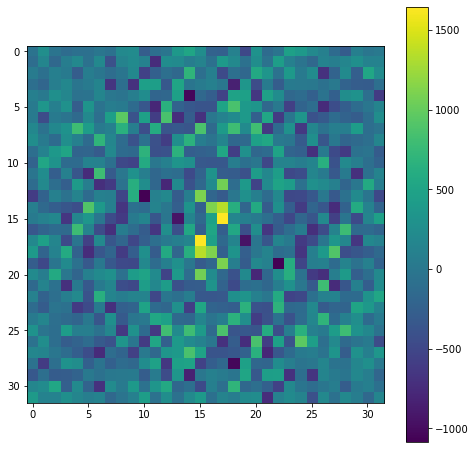

In [397]:
plt.imshow(jnp.real(jnp.fft.fftshift(imgs_f[idx].reshape([32,32])))); plt.colorbar()

In [380]:
img_idx = jnp.fft.fftshift(imgs_f[idx].reshape([32,32]))

In [443]:
sigma_noise = estimate_real_noise(jnp.abs(imgs_f))

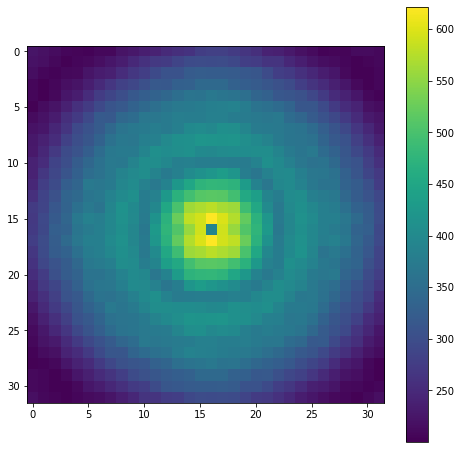

In [437]:
plt.imshow(jnp.fft.fftshift(sd_real.reshape([32,32]))); plt.colorbar()